该例子的解是q9q8q7q6q5q4q3q2q1q0 = 0111010011。该例子的哈密顿量最小值为 0.5b-5a，即网络训练后需要收敛到的最优值

若按作者论文设置，取b=0.5，a=（权重求和）*b+0.1。即b=0.5,a=33.6，则最小值为-167.75

当A=B=1时，多次实验最终敲定学习率为 0.1最为合适。学习率0.2有一点大，会让训练过程变得不稳定。训练迭代500次足矣

In [1]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, ZZ, RX, XX, YY, RY, X
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import inner_product, Simulator
from mindquantum.algorithm.nisq import HardwareEfficientAnsatz
from mindquantum.core.circuit import shift, Circuit
from mindquantum.core.operators import TimeEvolution, QubitOperator
from mindspore.common.parameter import Parameter

import matplotlib.pyplot as plt
import networkx as nx
import mindspore.nn as nn
import mindspore as ms
import numpy as np  
import random
import pandas as pd


In [2]:
qubit_num = 8
A = 5.5
B = 0.5
#需要做试验，找到A和B的最佳占比。可令 A = 15，B分别取 1,3,5,7,9,13
# min H_C = 5B , 即要训练的最小值是 5

# 搭建混合层线路

In [3]:
def build_hb():
    hb = QubitOperator()
    for i in range(qubit_num):
        hb += QubitOperator('X{}'.format(i), 1)
    return hb

1 [X0] +
1 [X1] +
1 [X2] +
1 [X3] +
1 [X4] +
1 [X5] +
1 [X6] +
1 [X7]


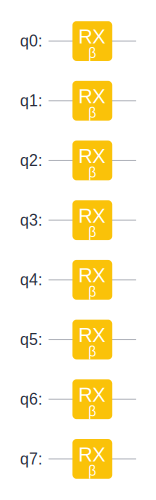

In [4]:
hb = build_hb()
print (hb)
circuit1 = TimeEvolution(hb,{'β':0.5}).circuit
circuit1.svg()

# 定义问题哈密顿量Construct_Hamiltonian_C()，并搭建线路circuit2

In [5]:
def Construct_Hamiltonian_C():
    H_C = QubitOperator() 
    
    H_C += QubitOperator('Z0', 0.75*A-0.5*B) + QubitOperator('Z1', 0.5*A-4.5*B)+ QubitOperator('Z2', 0.75*A-2.5*B)+ QubitOperator('Z3', 0.75*A-1.5*B)+ QubitOperator('Z4', 0.5*A-0.5*B)+ QubitOperator('Z5', A-2.5*B)+ QubitOperator('Z6',A-2.5*B)+ QubitOperator('Z7', 0.75*A-2*B)
   
    H_C += QubitOperator('Z{} Z{}'.format(0,2), 0.25*A)+QubitOperator('Z{} Z{}'.format(0,3), 0.25*A)+QubitOperator('Z{} Z{}'.format(0,6), 0.25*A)+QubitOperator('Z{} Z{}'.format(1,6), 0.25*A)+QubitOperator('Z{} Z{}'.format(1,7), 0.25*A)+QubitOperator('Z{} Z{}'.format(2,3), 0.25*A)+QubitOperator('Z{} Z{}'.format(2,7), 0.25*A)+QubitOperator('Z{} Z{}'.format(3,5), 0.25*A)+QubitOperator('Z{} Z{}'.format(4,5), 0.25*A)+QubitOperator('Z{} Z{}'.format(4,6), 0.25*A)+QubitOperator('Z{} Z{}'.format(5,6), 0.25*A)+QubitOperator('Z{} Z{}'.format(5,7), 0.25*A)
    return H_C

In [6]:
# 搭建线路时要去掉单位算子，但问题哈密顿量不用
#hc = H_C -(4*A+5*B)* QubitOperator(())
hc = Construct_Hamiltonian_C()
print (hc)

3.875 [Z0] +
  1/2 [Z1] +
2.875 [Z2] +
3.375 [Z3] +
  5/2 [Z4] +
 17/4 [Z5] +
 17/4 [Z6] +
3.125 [Z7] +
1.375 [Z0 Z2] +
1.375 [Z0 Z3] +
1.375 [Z0 Z6] +
1.375 [Z1 Z6] +
1.375 [Z1 Z7] +
1.375 [Z2 Z3] +
1.375 [Z2 Z7] +
1.375 [Z3 Z5] +
1.375 [Z4 Z5] +
1.375 [Z4 Z6] +
1.375 [Z5 Z6] +
1.375 [Z5 Z7]


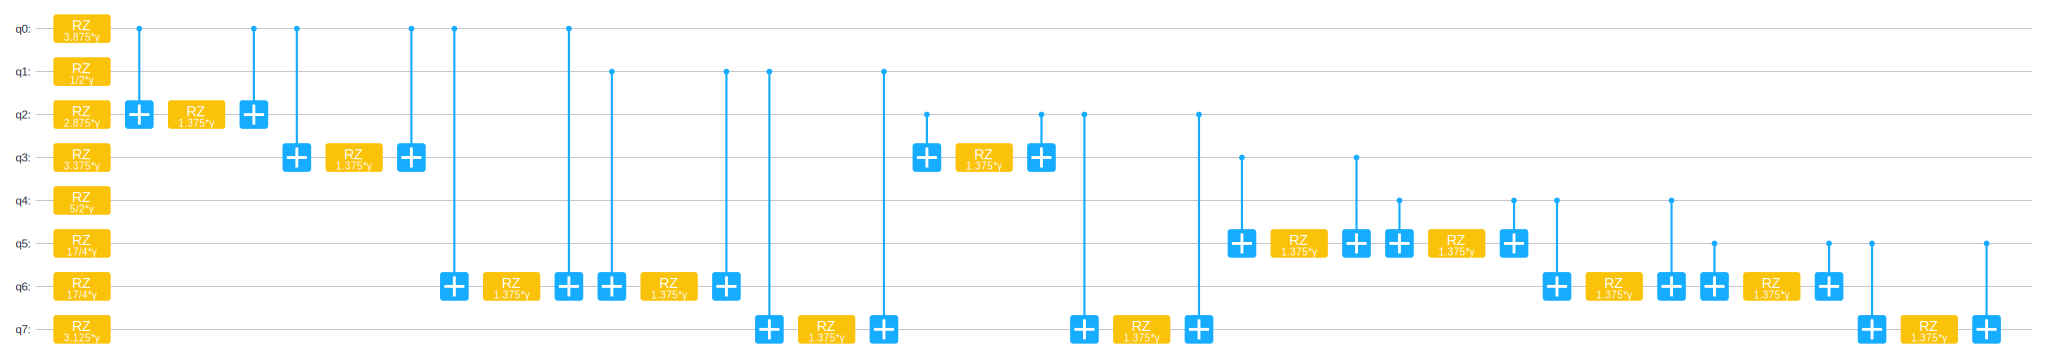

In [7]:
circuit2 = TimeEvolution(hc,{'γ':0.5}).circuit
circuit2.svg()

# 总线路circ

In [8]:
def build_ansatz(p):                    # p是ansatz线路的层数
    circ = UN(H, qubit_num)
    for i in range(p):
        circ += TimeEvolution(hc,{f'γ{i}':0.5}).circuit    # 添加Uc对应的线路，参数记为g0、g1、g2...     
        circ += TimeEvolution(hb,{f'β{i}':0.5}).circuit    # 添加Ub对应的线路，参数记为b0、b1、b2...
    return circ

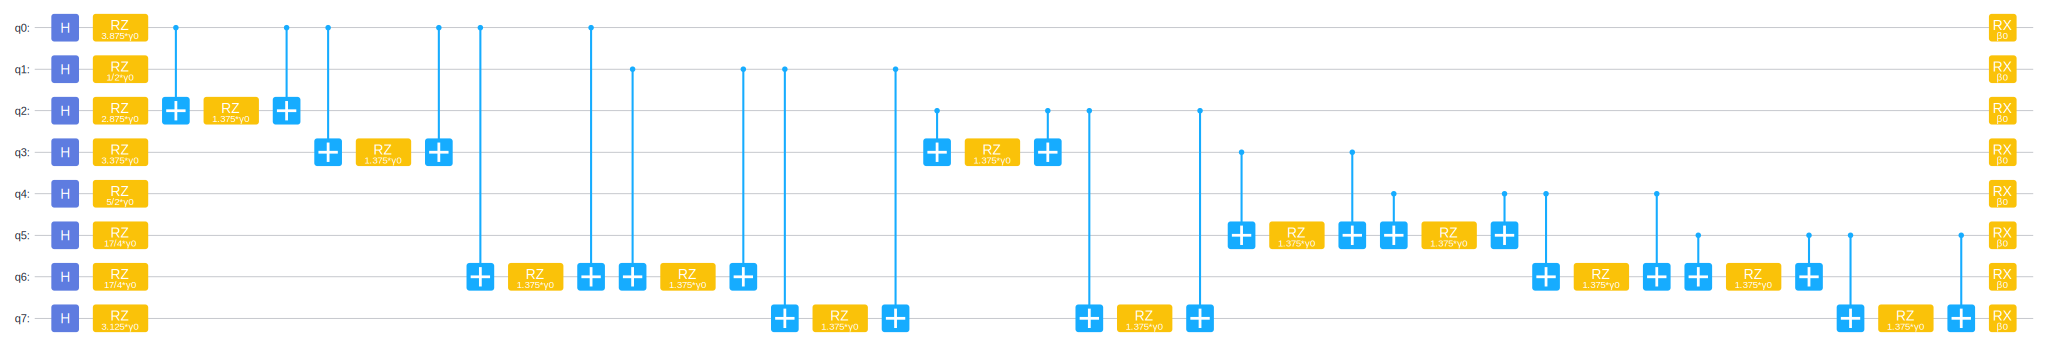

In [9]:
#一层深度8
#打印一层circuit，检查正确性
p=1
circ = build_ansatz(p)
#circ.summary() 
circ.svg()

# 单次训练

In [21]:
p = 8
ham = Hamiltonian(Construct_Hamiltonian_C()) # 生成哈密顿量
circ = build_ansatz(p)

ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
sim = Simulator('mqvector', circ.n_qubits)                     # 创建模拟器，backend使用‘mqvector’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
net.weight = Parameter((np.random.rand(len(net.weight))*np.pi).astype(np.float32))
Iparameter = dict(zip(circ.params_name, net.weight.asnumpy()))

opti = nn.Adam(net.trainable_params(), learning_rate = 0.05)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net = nn.TrainOneStepCell(net, opti)                     # 对神经网络进行一步训练                   # 对神经网络进行一步训练


for i in range(500):
    energy = train_net()    # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步

    if i%10 ==0:
        print('i = %d energy = %f'%(i,energy))

i = 0 energy = -0.110050
i = 10 energy = -2.314849
i = 20 energy = -3.191561
i = 30 energy = -3.434652
i = 40 energy = -3.526541
i = 50 energy = -3.575145
i = 60 energy = -3.616449
i = 70 energy = -3.944497
i = 80 energy = -4.248611
i = 90 energy = -4.452913
i = 100 energy = -4.965107
i = 110 energy = -6.753436
i = 120 energy = -10.134123
i = 130 energy = -12.309899
i = 140 energy = -13.229835
i = 150 energy = -13.532953
i = 160 energy = -13.807986
i = 170 energy = -13.994253
i = 180 energy = -14.092273
i = 190 energy = -14.105442
i = 200 energy = -14.108054
i = 210 energy = -14.113417
i = 220 energy = -14.115097
i = 230 energy = -14.115902
i = 240 energy = -14.116496
i = 250 energy = -14.116768
i = 260 energy = -14.116920
i = 270 energy = -14.117009
i = 280 energy = -14.117053
i = 290 energy = -14.117077
i = 300 energy = -14.117088
i = 310 energy = -14.117094
i = 320 energy = -14.117096
i = 330 energy = -14.117098
i = 340 energy = -14.117098
i = 350 energy = -14.117098
i = 360 energy 

In [22]:
pr = dict(zip(circ.params_name, net.weight.asnumpy())) # 获取线路参数
state = circ.get_qs(pr=pr)

v1 = [0]* 2**qubit_num
v1[217] = 1       #这里指定的量子态v也是降序的qubits，即应该是q2q1q0,即应该是110，化为十进制是1*2^2+1*2^1+0*2^0=6
fid1 = np.abs(np.vdot(v1,state))**2 

#v2 = [0]* 2**qubit_num
#v2[124] = 1       #这里指定的量子态v也是降序的qubits，即应该是q2q1q0,即应该是110，化为十进制是1*2^2+1*2^1+0*2^0=6
#fid2 = np.abs(np.vdot(v2,state))**2

state = circ.get_qs(pr=pr,ket=True)
#print('untrained quantum states:{}'.format(state)) #检查输出态是否满足可行解空间
print('initial parameter is: {}'.format(Iparameter))   #检查初始参数是否是从（0,π选的）

print(('optimal parameter: {}'.format(pr)))
print('fid1: {}'.format(fid1))
#print('fid2: {}'.format(fid2))
#print('获得解的概率: {}'.format(fid1+fid2))
print('The F value is: {}'.format(energy))

initial parameter is: {'γ0': 1.0158465, 'β0': 2.3216794, 'γ1': 0.9441605, 'β1': 2.5575032, 'γ2': 2.911467, 'β2': 0.19780953, 'γ3': 2.2414818, 'β3': 2.4197164, 'γ4': 3.0177975, 'β4': 3.0950334, 'γ5': 2.8772397, 'β5': 0.9163176, 'γ6': 2.5238369, 'β6': 0.7147124, 'γ7': 1.3451204, 'β7': 1.0466696}
optimal parameter: {'γ0': 0.19156955, 'β0': 1.5990205, 'γ1': 0.3020248, 'β1': 3.8496132, 'γ2': 3.845544, 'β2': 0.28266835, 'γ3': 1.917161, 'β3': 5.5562525, 'γ4': 2.7716818, 'β4': 2.872253, 'γ5': 2.0259755, 'β5': 1.6919543, 'γ6': 2.5302367, 'β6': 1.0073456, 'γ7': 1.9851377, 'β7': 0.42173547}
fid1: 0.33434780353198307
The F value is: [-14.117098]


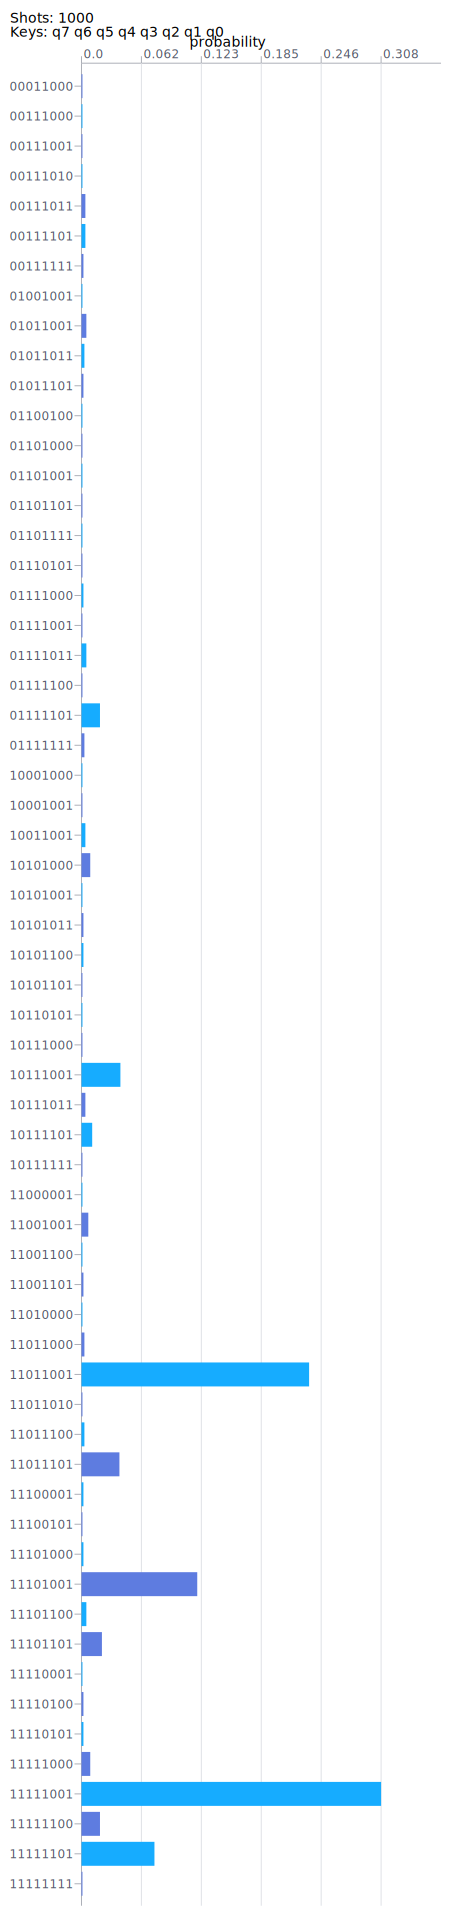

In [12]:
circ.measure_all()                               # 为线路中所有比特添加测量门
sim.sampling(circ, pr=pr, shots=1000).svg()

# _main_文件（主要是为了画能量损失函数图和成功概率随层数增长变化图）

In [23]:
if __name__ == "__main__":
    #创建一个空的DataFrame来存储结果
    results = []

    for p in range(1, 9):
        print('The p value is: {}'.format(p))
        for t in range(1, 501):
            ham = Hamiltonian(Construct_Hamiltonian_C()) # 生成哈密顿量
            circ = build_ansatz(p)                  # 生成ansatz线路

            ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
            sim = Simulator('mqvector', circ.n_qubits)                     # 创建模拟器，backend使用‘mqvector’，能模拟5个比特（'circ'线路中包含的比特数）
            grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
            net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
            net.weight = Parameter((np.random.rand(len(net.weight)) * np.pi).astype(np.float32))
            theta = dict(zip(circ.params_name, net.weight.asnumpy()))

            opti = nn.Adam(net.trainable_params(), learning_rate = 0.05)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
            train_net = nn.TrainOneStepCell(net, opti)                     # 对神经网络进行一步训练                       
                
            
            for i in range(500):
                energy = train_net()
                #if i%100 == 0:
                #    print('i = %d energy = %f'%(i,energy))
                
            pr = dict(zip(circ.params_name, net.weight.asnumpy())) 
            state = circ.get_qs(pr=pr)
            
            v1 = [0]* 2**qubit_num
            v1[217] = 1
            fid1 = np.abs(np.vdot(v1,state))**2 

            # 将结果添加到列表
            results.append({"p": p, "t": t, "energy": energy, "fidelity": fid1})
            
            #命令交互行输出，便于区分（实际上没啥必要）
            
            #print('t={}'.format(t))

        # 将列表转换为DataFrame
        df = pd.DataFrame(results)

        # 将DataFrame写入Excel文件
        df.to_excel("/home/lzztlb/liguanghui/AAResearch/liguanghui（code)/科研/MWVC/AQT所用/MWVCv2_AQT_v1/compare QAOA/8/QAOA data/QAOA8-5.xlsx", index=False)
    

The p value is: 1
The p value is: 2
The p value is: 3
The p value is: 4
The p value is: 5
The p value is: 6
The p value is: 7
The p value is: 8
